In [2]:
# Import libraries
#import pgmpy.models
#import pgmpy.inference
import numpy as np
import pysmile
import pysmile_license
import os
import pandas as pd
import math
from enum import Enum
import matplotlib.pyplot as plt

In [3]:
numSlices = 24

class NodeNames(Enum):
    MITM = "MITM"
    SRM = "SRM"
    UC = "UC"
    UPS = "UPS"
    IMD = "IMD"
    MC = "MC"
    CC = "CC"

PySmile Network

In [4]:
DEBUG = False

evidenceNodes = [NodeNames.IMD.value, NodeNames.MC.value, NodeNames.CC.value]

classNodesHandles = dict()

In [5]:
def print_node_info(net, node_handle):
    print("Node id/name: " + net.get_node_id(node_handle) + "/" +
    net.get_node_name(node_handle))
    print(" Outcomes: " + " ".join(net.get_outcome_ids(node_handle)))
    parent_ids = net.get_parent_ids(node_handle)
    if len(parent_ids) > 0:
        print(" Parents: " + " ".join(parent_ids))
    child_ids = net.get_child_ids(node_handle)
    if len(child_ids) > 0:
        print(" Children: " + " ".join(child_ids))
    print_cpt_matrix(net, node_handle)
    
def print_cpt_matrix(net, node_handle):
    cpt = net.get_node_definition(node_handle)
    parents = net.get_parents(node_handle)
    dim_count = 1 + len(parents)
    dim_sizes = [0] * dim_count
    for i in range(0, dim_count - 1):
        dim_sizes[i] = net.get_outcome_count(parents[i])
    dim_sizes[len(dim_sizes) - 1] = net.get_outcome_count(node_handle)
    coords = [0] * dim_count
    for elem_idx in range(0, len(cpt)):
        index_to_coords(elem_idx, dim_sizes, coords)
        outcome = net.get_outcome_id(node_handle, coords[dim_count - 1])
        out_str = " P(" + outcome
        if dim_count > 1:
            out_str += " | "
            for parent_idx in range(0, len(parents)):
                if parent_idx > 0:
                    out_str += ","
                parent_handle = parents[parent_idx]
                out_str += net.get_node_id(parent_handle) + "=" + \
                net.get_outcome_id(parent_handle, coords[parent_idx])
        prob = cpt[elem_idx]
        out_str += ")=" + str(prob)
        print(out_str)
    
        
def index_to_coords(index, dim_sizes, coords):
    prod = 1
    for i in range(len(dim_sizes) - 1, -1, -1):
        coords[i] = int(index / prod) % dim_sizes[i]
        prod *= dim_sizes[i]

def pint_time_cpt_marix(net, nodeHandle):
    timeCPT = net.get_node_temporal_definition(nodeHandle, 1)
    
        
def plot_time_CPT(net, nodeHandle):    
    cpt = net.get_node_temporal_definition(nodeHandle, 1)
    print(len(cpt))
    print("###")
    
def print_net_info(net, unrolled = True):
    for n in net.get_all_nodes():
        print_node_info(net, n)
        if not unrolled and net.get_node_id(n) == NodeNames.UPS.value:
            plot_time_CPT(net, n)
            
def calc_stat(confMatrix, outcome, type='P'):
    TP = confMatrix[outcome][outcome]
    FP = 0
    TN = 0
    FN = 0
    for i in range(0, len(confMatrix)):
        for j in range(0, len(confMatrix[i])):
            if i == outcome and j != outcome:
                FP += confMatrix[i][j]
            if j == outcome and i != outcome:
                FN += confMatrix[i][j]
            if i != outcome and j != outcome:
                TN += confMatrix[i][j] 
                
    if type == 'P':
        if TP + FP == 0: return float('nan')
        return TP / (TP + FP)
    if type == 'A':
        if TP + TN + FP + FN == 0: return float('nan')
        return  (TP+TN) / (TP + TN + FP + FN)
    if type == 'R':
        if TP + FN == 0: return float('nan')
        return TP / (TP + FN)
    if type == 'F':
        if (2*TP)+FP+FN == 0: return float('nan')
        return (2*TP)/((2*TP)+FP+FN)        

def print_validator_results(net, originalSliceCount, validator, nodeId): 
    nodeHandle = classNodesHandles[nodeId]
    outcomeCount = net.get_outcome_count(nodeHandle)
    accMtrx = np.zeros((outcomeCount, 2, originalSliceCount))
    precMtrx = np.zeros((outcomeCount, 2, originalSliceCount))
    recMtrx = np.zeros((outcomeCount, 2, originalSliceCount))
    fMtrx = np.zeros((outcomeCount, 2, originalSliceCount))
    
    
    for slice in range(1, originalSliceCount):
        if DEBUG: print("### Slice " + str(slice) + " ###")
        nodeHandle = classNodesHandles[nodeId + "_" + str(slice)]
        cm = validator.get_confusion_matrix(nodeHandle)
        for i in range(0, outcomeCount):
            acc = calc_stat(cm, i, 'A')
            # If the calculated statistic is NaN assign 0 (see next line)
            accMtrx[i][0][slice] = acc if not math.isnan(acc) else 0
            # If the calculated statistic is NaN assign weight 0 to it
            # otherwise use the number of elements belonging to that class as weight
            accMtrx[i][1][slice] = np.sum(cm[:][i]) if not math.isnan(acc) else 0
            prec = calc_stat(cm, i, 'P')
            precMtrx[i][0][slice] = prec if not math.isnan(prec) else 0
            precMtrx[i][1][slice] = np.sum(cm[:][i]) if not math.isnan(prec) else 0
            rec = calc_stat(cm, i, 'R')
            recMtrx[i][0][slice] = rec if not math.isnan(rec) else 0
            recMtrx[i][1][slice] = np.sum(cm[:][i]) if not math.isnan(rec) else 0
            f = calc_stat(cm, i, 'F')
            fMtrx[i][0][slice] = f if not math.isnan(f) else 0
            fMtrx[i][1][slice] = np.sum(cm[:][i]) if not math.isnan(f) else 0
            
            if DEBUG:
                print("Accuracy for " + nodeId + str(i) + ": " + str(acc))
                print("Precision for " + nodeId + str(i) + ": " + str(prec))
                print("Recall for " + nodeId + str(i) + ": " + str(rec))    
        if DEBUG:    
            print("** Confusion Matrix **")
            for i in range(0, outcomeCount):
                print(cm[i])
            print("")
    
    # Calculates weighted averages (each statistic of each timeslice is weighted
    # by the number of elements nelonging to that class in that timeslice)
    for i in range(0, outcomeCount):
        avgAcc = np.sum(accMtrx[i][0]*accMtrx[i][1])/np.sum(accMtrx[i][1])
        print("Average Accuracy for " + nodeId + str(i) + ": " + str(avgAcc))
        avgPrec = np.sum(precMtrx[i][0]*precMtrx[i][1])/np.sum(precMtrx[i][1])
        print("Average Precision for " + nodeId + str(i) + ": " + str(avgPrec))
        avgRec = np.sum(recMtrx[i][0]*recMtrx[i][1])/np.sum(recMtrx[i][1])
        print("Average Recall for " + nodeId + str(i) + ": " + str(avgRec))
        avgF = np.sum(fMtrx[i][0]*fMtrx[i][1])/np.sum(fMtrx[i][1])
        print("Average F-score for " + nodeId + str(i) + ": " + str(avgF))
        print("") 
        
def eraseDefinitions(net):
    nodes = net.get_all_node_ids()
    for node in nodes:
        cpt = net.get_node_definition(node)
        numOutcomes = net.get_outcome_count(node)
        p = 1 / numOutcomes
        for i in range(0, len(cpt)):
            cpt[i] = p
        net.set_node_definition(node, cpt)

def eraseTemporalDefinitions(net):
    nodes = net.get_all_node_ids()
    for node in nodes:
        try:
            cpt = net.get_node_temporal_definition(node, 1)
            numOutcomes = net.get_outcome_count(node)
            p = 1 / numOutcomes
            for i in range(0, len(cpt)):
                cpt[i] = p
            net.set_node_temporal_definition(node, 1, cpt)  
        except:
            print("No temporal definition for node " + net.get_node_name(node))  

In [6]:
# Create and read the DBN from file
net = pysmile.Network()
ds = pysmile.learning.DataSet()

net.read_file(os.getcwd() + "/../../../Genie-DBN/DBN-MITM.xdsl")
    

Erase CPTs before training

In [7]:
eraseDefinitions(net)
eraseTemporalDefinitions(net)

No temporal definition for node UnstablePS
No temporal definition for node MeasureCoherence
No temporal definition for node CommandCoherence
No temporal definition for node IrregularMessageDelivery


Traininig

In [8]:
df = pd.read_csv(os.getcwd() + "/outTrain.csv")
ds.read_pandas_dataframe(df)

matching = ds.match_network(net)
em = pysmile.learning.EM()
# Small data variatons correspond to big changes
em.set_relevance(0)
res = em.learn(ds, net, matching)

print("N-LL: " + str(em.get_last_score()))

N-LL: -220920.3377343849


Test performances

In [9]:
def testPerf(net):
    df = pd.read_csv(os.getcwd() + "/outTest.csv")
    ds.read_pandas_dataframe(df)
    
    unrolledNet = net.unroll().unrolled     
    matching = ds.match_network(unrolledNet)
    validator = pysmile.learning.Validator(unrolledNet, ds, matching)
    # Set class nodes (those that will not be considered as evidence nodes)
    for elem in NodeNames.__members__:
        if elem not in evidenceNodes:
            classNodesHandles[elem] = unrolledNet.get_node(elem)
            validator.add_class_node(classNodesHandles[elem])
            for slice in range(1, net.get_slice_count()):
                elemCat = elem + "_" + str(slice)
                classNodesHandles[elemCat] = unrolledNet.get_node(elemCat)
                validator.add_class_node(classNodesHandles[elemCat])
    # Test the predctions on the class nodes            
    validator.test()
    print_validator_results(unrolledNet, net.get_slice_count(), validator, NodeNames.SRM.value)


    if DEBUG:
        print_net_info(unrolledNet, unrolled=True)

In [10]:
def compare_files(trainFileName, testFileName):
    dfTrain = pd.read_csv(os.getcwd() + "/" + trainFileName)
    dfTest = pd.read_csv(os.getcwd() + "/" + testFileName)
    
    dfOut = pd.concat([dfTrain, dfTest]).drop_duplicates(keep="first")
    dups  = dfTrain.shape[0] + dfTest.shape[0] - dfOut.shape[0]
    print(dfTrain.shape[0])
    print(dfTest.shape[0])
    print("Duplicate rows: " + str(dups))
    
compare_files("outTrain.csv", "outTrain.csv")

4800
4800
Duplicate rows: 4801


Test learning capabilities

N-LL: -365.6941374848874
Average Accuracy for SRM0: 0.9854510290468546
Average Precision for SRM0: 0.9970807181433368
Average Recall for SRM0: 0.9675522164650879
Average F-score for SRM0: 0.981192064573632

Average Accuracy for SRM1: 0.8958452851496329
Average Precision for SRM1: 0.6990400903444381
Average Recall for SRM1: 0.694305045091998
Average F-score for SRM1: 0.6943591356508911

Average Accuracy for SRM2: 0.8645293677515901
Average Precision for SRM2: 0.7242798353909465
Average Recall for SRM2: 0.6242308254648624
Average F-score for SRM2: 0.6596813942829949

Average Accuracy for SRM3: 0.9274
Average Precision for SRM3: 0.9161747343565525
Average Recall for SRM3: 0.9821775916543569
Average F-score for SRM3: 0.9478136015829782

N-LL: -828.0046158919922
Average Accuracy for SRM0: 0.9818359363596554
Average Precision for SRM0: 0.9846737702525179
Average Recall for SRM0: 0.9688645203112886
Average F-score for SRM0: 0.9763066318858699

Average Accuracy for SRM1: 0.8926092603049126
Ave

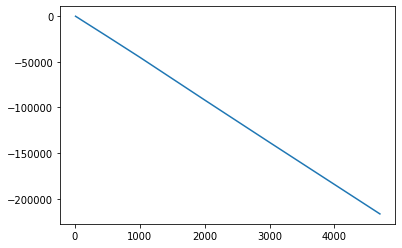

In [12]:
populations = [10, 20, 50, 100, 500, 1000, 2000, 3000, 4700]
nlls = []
df = pd.read_csv(os.getcwd() + "/outTrain.csv")
for pop in populations:
    ds.read_pandas_dataframe(df[0:pop])
    matching = ds.match_network(net)
    em = pysmile.learning.EM()
    # Small data variatons correspond to big changes
    em.set_relevance(0)
    res = em.learn(ds, net, matching)
    nlls.append(em.get_last_score())
    print("N-LL: " + str(em.get_last_score()))
    
    testPerf(net)

plt.plot(populations, nlls)